In [15]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
# matplotlib.rcParams['font.sans-serif'] = ['SimHei']
# import pandas as pd
# from pandas import Series, DataFrame
# from pandas import concat
# pd.set_option('display.max_columns', None)
#显示所有行
import tensorflow as tf
from pyhive import hive

In [16]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from math import sqrt
# from sklearn.ensemble import RandomForestRegressor
 #fix random seed for reproducibility
np.random.seed(2019)

In [17]:
def create_dataset(dataset, look_back=7, n_predict=3):   
    X, Y = [], []
    for i in range(len(dataset)-look_back-n_predict+1): 
        obs = dataset[i:(i+look_back), 0]
# Sequence of 7 stock prices as features forming an observation
# Append sequence
        X.append(obs)
       # Append stock price value occurring 4 time-steps into future
        Y.append(dataset[i+look_back:i + (look_back+n_predict), 0]) 
    return np.array(X), np.array(Y)

In [18]:
def find_max(data,span=1):
    data_len = data.shape[0]
    span_len = data_len//span
    span_max_all = []
    for i in range(span_len):
        span_max = np.max(data[i*span:(i+1)*span])
        span_max_all.append(span_max)
    span_max_all = np.array(span_max_all)
    return span_max_all.reshape(-1,1)

In [19]:
def outlier_process(data,thre=3):
    data_output= data.copy()
    [r, l] = data.shape
    for i in range(r):
        for j in range(l):
           
            if i == 0:
                if (data[i,j]>thre*data[i+1,j] and data[i,j]>thre*data[i+2,j]) or (data[i,j]<data[i+1,j]/thre and data[i,j]<data[i+2,j]/thre):
                    data_output[i,j] = (data[i+1,j]+data[i+2,j])/2
            elif i>0 and i<r-1:
                
                if (data[i,j]>thre*data[i-1,j] and data[i,j]>thre*data[i+1,j]) or (data[i,j]<data[i-1,j]/thre and data[i,j]<data[i+1,j]/thre):
                    data_output[i,j] = (data[i-1,j]+data[i+1,j])/2
            else:
                if (data[i,j]>thre*data[i-1,j] and data[i,j]>thre*data[i-2,j]) or (data[i,j]<data[i-1,j]/thre and data[i,j]<data[i-2,j]/thre):
                    data_output[i,j] = (data[i-1,j]+data[i-2,j])/2
    return data_output 

In [20]:
def persistence(last_ob, n_predict):
    return [last_ob for i in range(n_predict)]

In [21]:
def mape_error(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

In [22]:
def mae_error(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

In [23]:
def corr_find(data1,data2):
    cor = stats.pearsonr(data1, data2)
    return cor[0]

In [24]:
def data_sum(data):
    return data.sum(axis=1)

In [25]:
def z_normal(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    data_nor = (data-data_mean)/data_std
    return data_nor,data_mean,data_std

In [26]:
def inv_z_normal(data,data_mean,data_std):
    data_inv = data*data_std+data_mean
    return data_inv

In [27]:
traffic = np.load('t_sum_GEANT.npy')
citys = ['12','13','19','23','8','18','4','1','5','3','10',
         '22','7','2','6','16','14','20','11','9','17','21','15']

In [28]:
# 选择某个终点城市
start_city = '16'
start_city_num = citys.index(start_city)
raw_data = traffic[start_city_num, :, :].transpose()
sum_city = np.zeros(raw_data[:,1].shape)
# %matplotlib auto
end_city = '5'
end_city_num = citys.index(end_city)
#raw_data_uni = raw_data[:,end_city_num]

conn = hive.Connection(host='10.1.1.7', port=10000, username='hive', database='test')
cursor = conn.cursor()
sql="select dst5 from IntraTM2 where srcid='16'"
cursor.execute(sql)
result=cursor.fetchall()
raw_data_uni = np.array(result).astype('float')
raw_data_uni = raw_data_uni.reshape(-1,)

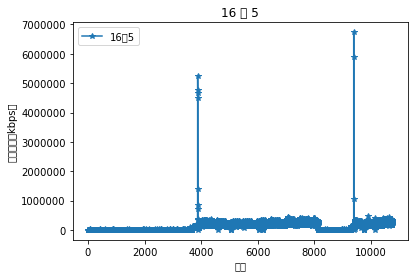

In [29]:
plt.figure()
plt.plot(range(1,len(raw_data_uni)+1), raw_data_uni, '-*',label= start_city+'到'+end_city)
plt.legend()
plt.xlabel('时间')
plt.ylabel('峰值流速（kbps）')
plt.title('%s 到 %s'%(start_city,end_city))
plt.show()

In [30]:
raw_data_uni[raw_data_uni >500000]=0

/root/anaconda3/envs/testenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


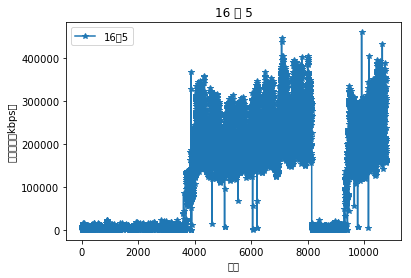

In [31]:
plt.figure()
plt.plot(range(1,len(raw_data_uni)+1), raw_data_uni, '-*',label= start_city+'到'+end_city)
plt.legend()
plt.xlabel('时间')
plt.ylabel('峰值流速（kbps）')
plt.title('%s 到 %s'%(start_city,end_city))
plt.show()

In [32]:
raw_data_uni_partial = raw_data_uni[-24*4*7*2-24*4*7:]

In [33]:
raw_data_uni_partial.shape

(2016,)

In [34]:
-24*4*7*2-24*4*7

-2016

In [35]:
raw_data_uni_partial

array([   9024.2311,    9573.9822,    7541.3067, ...,  194541.1111,
        210943.3422,  236446.6489])

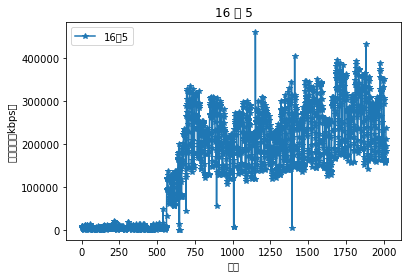

In [36]:
plt.figure()
plt.plot(range(1,len(raw_data_uni_partial)+1), raw_data_uni_partial, '-*',label= start_city+'到'+end_city)
plt.legend()
plt.xlabel('时间')
plt.ylabel('峰值流速（kbps）')
plt.title('%s 到 %s'%(start_city,end_city))
plt.show()

In [37]:
train_size = 24*4*7*2
validation_size = 0
test_size = 24*4*7

look_back = 24*4
n_predict = 24*4*2

In [38]:
raw_data_uni_partial = raw_data_uni_partial.reshape(-1,1)
print(raw_data_uni_partial.shape)
train_max = raw_data_uni_partial[:train_size].max(axis=0)
print(train_max)
train_min = raw_data_uni_partial[:train_size].min(axis=0)

raw_data_uni_partial = (raw_data_uni_partial-train_min)/(train_max-train_min)
raw_data_uni_partial = raw_data_uni_partial.reshape(-1,1)

(2016, 1)
[ 459080.1956]


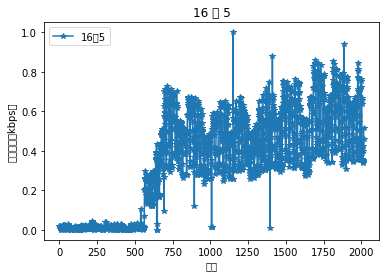

In [39]:
plt.figure()
plt.plot(range(1,len(raw_data_uni_partial)+1), raw_data_uni_partial, '-*',label= start_city+'到'+end_city)
plt.legend()
plt.xlabel('时间')
plt.ylabel('峰值流速（kbps）')
plt.title('%s 到 %s'%(start_city,end_city))
plt.show()

In [40]:
train_data = create_dataset(raw_data_uni_partial[:train_size], look_back=look_back, n_predict=n_predict)

In [41]:
# validation_data = create_dataset(raw_data_uni_partial[train_size:train_size+validation_size], look_back=look_back, n_predict=n_predict)
test_data = create_dataset(raw_data_uni_partial[train_size+validation_size:train_size+validation_size+test_size], look_back=look_back, n_predict=n_predict)

In [42]:
train_x = train_data[0]
train_y = train_data[1]
# validation_x = validation_data[0]
# validation_y = validation_data[1]
test_x = test_data[0]
test_y = test_data[1]

In [43]:
n_feature = 1

In [44]:
n_obs = look_back * n_feature  # 一个样本中的所有输入特征

train_x = train_x.reshape((train_x.shape[0], look_back, n_feature))
# validation_x = validation_x.reshape((validation_x.shape[0], look_back, n_feature))
test_x = test_x.reshape((test_x.shape[0], look_back, n_feature))
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(1057, 96, 1) (1057, 192) (385, 96, 1) (385, 192)


In [45]:
# design network
# design network
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(120, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(tf.keras.layers.LSTM(120, return_sequences=True))
model.add(tf.keras.layers.LSTM(120, dropout=0.1, recurrent_dropout=0.5))

# model.add(Densense(512))
model.add(tf.keras.layers.Dense(n_predict))
model.compile(loss='mae', optimizer='adam')
model.summary()

# fit network


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 96, 120)           58560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 96, 120)           115680    
_________________________________________________________________
lstm_2 (LSTM)                (None, 120)               115680    
_________________________________________________________________
dense (Dense)                (None, 192)               23232     
Total params: 313,152
Trainable params: 313,152
Non-trainable params: 0
_________________________________________________________________


In [46]:
history = model.fit(train_x, train_y, epochs=50, batch_size=32, validation_data=(test_x, test_y), verbose=1, shuffle=False)
# plot history

Train on 1057 samples, validate on 385 samples
Epoch 1/50
1057/1057 [==============================] - 11s 11ms/step - loss: 0.1557 - val_loss: 0.1400
Epoch 2/50
1057/1057 [==============================] - 9s 9ms/step - loss: 0.3123 - val_loss: 0.4695
Epoch 3/50
1057/1057 [==============================] - 9s 9ms/step - loss: 0.1955 - val_loss: 0.1685
Epoch 4/50
1057/1057 [==============================] - 9s 9ms/step - loss: 0.1650 - val_loss: 0.1497
Epoch 5/50
1057/1057 [==============================] - 9s 9ms/step - loss: 0.0989 - val_loss: 0.1579
Epoch 6/50
1057/1057 [==============================] - 9s 9ms/step - loss: 0.1355 - val_loss: 0.1558
Epoch 7/50
1057/1057 [==============================] - 9s 9ms/step - loss: 0.0960 - val_loss: 0.1582
Epoch 8/50
1057/1057 [==============================] - 9s 9ms/step - loss: 0.1052 - val_loss: 0.1575
Epoch 9/50
1057/1057 [==============================] - 9s 9ms/step - loss: 0.0912 - val_loss: 0.1579
Epoch 10/50
1057/1057 [==========

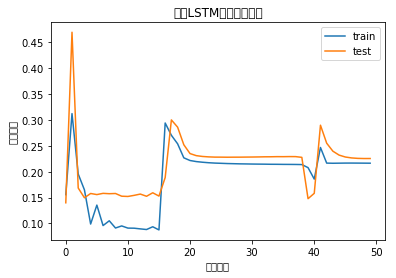

In [47]:
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('训练轮数')
plt.ylabel('损失函数')
plt.title('使用LSTM网络进行训练')
plt.legend()
plt.show()

In [48]:
# make a prediction
yhat = model.predict(test_x)
# 把 test_X 改造回原来形状，便于后续归一化操作
test_x = test_x.reshape((test_x.shape[0], look_back*n_feature))

In [49]:
yhat.shape

(385, 192)

In [50]:
raw_data_uni_partial = raw_data_uni_partial *(train_max-train_min)+train_min
raw_data_uni_partial

array([[   9024.2311],
       [   9573.9822],
       [   7541.3067],
       ..., 
       [ 194541.1111],
       [ 210943.3422],
       [ 236446.6489]])

In [51]:
# make a persistence forecast
def persistence(last_ob, n_predict):
    return [last_ob for i in range(n_predict)]

compare_base = raw_data_uni_partial[:, 0]
compare_base_total = []
for i in range(yhat.shape[0]):
    compare_base1 = compare_base[-yhat.shape[0]+i-1]
    compare_base2 = persistence(compare_base1, n_predict)
    compare_base_total.append(compare_base2)
compare_base_total = np.array(compare_base_total)
# print(compare_base_total)

In [52]:
inv_yhat = yhat*(train_max-train_min)+train_min
print(inv_yhat)
inv_yhat.shape

[[ 125642.46414809  125740.45216829  126205.88842345 ...,  185105.30801179
   185830.51786926  185968.47000662]
 [ 125642.46414809  125740.45216829  126205.88842345 ...,  185105.30801179
   185830.51786926  185968.47000662]
 [ 125642.46414809  125740.45216829  126205.88842345 ...,  185105.30801179
   185830.51786926  185968.47000662]
 ..., 
 [ 125642.46414809  125740.45216829  126205.88842345 ...,  185105.30801179
   185830.51786926  185968.47000662]
 [ 125642.46414809  125740.45216829  126205.88842345 ...,  185105.30801179
   185830.51786926  185968.47000662]
 [ 125642.46414809  125740.45216829  126205.88842345 ...,  185105.30801179
   185830.51786926  185968.47000662]]


(385, 192)

In [53]:
inv_y = test_y*(train_max-train_min)+train_min
inv_y.shape

(385, 192)

In [54]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('LSTM预测的RMSE: %.3f' % rmse)

LSTM预测的RMSE: 123095.597


In [55]:
rmse1 = sqrt(mean_squared_error(inv_y, compare_base_total))
print('简单预测的RMSE: %.3f'% rmse1)

简单预测的RMSE: 96748.198


In [56]:
# %matplotlib auto

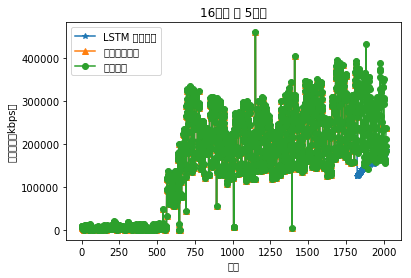

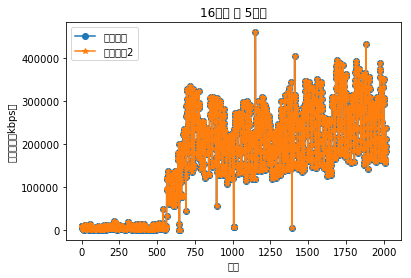

LSTM预测的RMSE: 123095.597
简单预测的RMSE: 96748.198


In [57]:
predict_data = raw_data_uni_partial[:, 0].copy()
predict_data[-n_predict:] = inv_yhat[-1]
compare_data = raw_data_uni_partial[:, 0].copy()
compare_data[-n_predict:] = compare_base_total[-n_predict]

actual_data = raw_data_uni_partial[:, 0].copy()
actual_data[-n_predict::] = inv_y[-1]

rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
rmse1 = sqrt(mean_squared_error(inv_y, compare_base_total))

mae = mae_error(inv_y, inv_yhat)
mae1 = mae_error(inv_y, compare_base_total)

mape = mape_error(inv_y, inv_yhat)
mape1 = mape_error(inv_y, compare_base_total)
# %matplotlib auto
plt.figure()
plt.plot(range(1,len(predict_data)+1),predict_data, '-*', label='LSTM 预测数据')
plt.plot(range(1, len(predict_data)+1),compare_data, '-^',label= '简单预测数据')
plt.plot(range(1,len(predict_data)+1), raw_data_uni_partial[:, 0], '-o',label= '实际数据')
plt.legend()
plt.xlabel('时间')
plt.ylabel('峰值流速（kbps）')
plt.title('%s 到 %s'%(start_city+'节点',end_city+'节点'))
# plt.text(0, 400000, 'LSTM预测的RMSE: %.3f'% rmse) 
# plt.text(0, 410000, '简单预测的RMSE: %.3f'% rmse1)
# plt.text(0, 430000, 'LSTM预测的MAE: %.3f'% mae) 
# plt.text(0, 420000, '简单预测的MAE: %.3f'% mae1)
# plt.text(0, 410000, 'LSTM预测的MAPE: %.3f'% mape+'%') 
# plt.text(0, 400000, '简单预测的MAPE: %.3f'% mape1+'%')
plt.show()

plt.figure()
plt.plot(range(1,len(predict_data)+1), raw_data_uni_partial[:, 0], '-o',label= '实际数据')
plt.plot(range(1,len(predict_data)+1), actual_data, '-*',label= '实际数据2')
plt.legend()
plt.xlabel('时间')
plt.ylabel('峰值流速（kbps）')
plt.title('%s 到 %s'%(start_city+'节点',end_city+'节点'))
plt.show()

rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('LSTM预测的RMSE: %.3f' % rmse)
rmse1 = sqrt(mean_squared_error(inv_y, compare_base_total))
print('简单预测的RMSE: %.3f'% rmse1)


# rmse_final = sqrt(mean_squared_error(inv_y[-1], inv_yhat[-1]))
# print('最后一批数据的LSTM预测的RMSE: %.3f' % rmse)
# rmse1_final = sqrt(mean_squared_error(inv_y[-1], compare_base_total[-n_predict]))
# print('最后一批数据的简单预测的RMSE: %.3f'% rmse1)

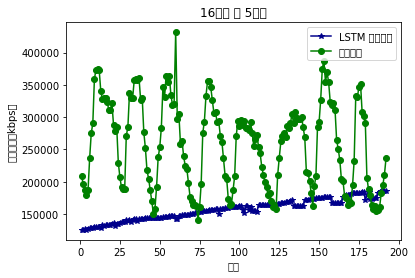

In [58]:
plt.figure()
plt.plot(range(1,len(inv_yhat[-1])+1), inv_yhat[-1], '-*',color='#00008B',label= 'LSTM 预测数据')
plt.plot(range(1,len(inv_y[-1])+1), inv_y[-1], '-o',color='#008000',label= '实际数据')
plt.legend()
plt.xlabel('时间')
plt.ylabel('峰值流速（kbps）')
plt.title('%s 到 %s'%(start_city+'节点',end_city+'节点'))
plt.show()